# Comparaison de modèles — NYC Taxi Fare Prediction

Ce notebook entraîne plusieurs modèles (LinearRegression (baseline), Ridge, Lasso, RandomForest, GradientBoosting)
et compare leurs performances (R2, RMSE, MAE) sur un même split train/test. Le chargement des données tente d'abord le fichier `datasets/original_cleaned_nyc_taxi_data_2018.csv` puis effectue un fallback si nécessaire.

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
print('Libraries loaded')

Libraries loaded


In [2]:
# Chargement des données (essayer plusieurs chemins pour être robuste)
paths_to_try = [
    'datasets/original_cleaned_nyc_taxi_data_2018.csv',
    '/Users/labelco-pilotes-video/Documents/machine-learning-taxi/Campaign-Analytics-Platform/datasets/original_cleaned_nyc_taxi_data_2018.csv'
]
df = None
for p in paths_to_try:
    if os.path.exists(p):
        print(f'Loading data from: {p}')
        df = pd.read_csv(p)
        break
if df is None:
    # Fallback: générer des données de démonstration (si le fichier n'existe pas)
    print('Dataset not found locally — using generated demo data')
    np.random.seed(42)
    n = 50000
    df = pd.DataFrame({
        'trip_distance': np.random.exponential(3, n),
        'trip_duration': np.random.exponential(900, n) + 60,
        'rate_code': np.random.choice([1,2,3], n, p=[0.9,0.08,0.02]),
        'payment_type': np.random.choice([1,2,3,4], n, p=[0.7,0.25,0.03,0.02]),
        'extra': np.random.choice([0,0.5,1], n),
        'mta_tax': np.full(n, 0.5),
        'tip_amount': np.random.exponential(1.5, n),
        'tolls_amount': np.random.choice([0,5.76,11.52], n, p=[0.85,0.1,0.05])
    })
    df['fare_amount'] = 2.5 + df['trip_distance']*2.5 + np.random.normal(0, 2, n)
# Aperçu
print('Data shape:', df.shape)
df.head()

Loading data from: datasets/original_cleaned_nyc_taxi_data_2018.csv
Data shape: (8319928, 21)


,Unnamed: 0,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
0,3,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,...,61.67,231,138,2018,3,29,3,13,3317.0,61.67
1,4,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,...,62.47,87,138,2018,3,29,3,14,3648.0,62.47
2,5,11.60,1,N,1,42.0,0.0,0.5,14.57,5.76,...,63.13,68,138,2018,3,29,3,14,3540.0,63.13
3,10,5.10,1,N,1,26.5,1.0,0.5,5.65,0.00,...,33.95,186,33,2018,3,29,3,16,2585.0,33.95
4,12,11.11,1,N,1,45.5,1.0,0.5,10.61,5.76,...,63.67,163,138,2018,3,29,3,16,4521.0,63.67


In [3]:
# Pré-traitement léger (échantillonnage optionnel pour accélérer)
SAMPLE_SIZE = 100000
if len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=42)
# Nettoyage conforme au notebook principal
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 200) & (df['trip_distance'] > 0) & (df['trip_distance'] < 100) & (df['trip_duration'] > 60) & (df['trip_duration'] < 7200)].copy()
print('After cleaning:', df.shape)

After cleaning: (97784, 21)


In [4]:
# Définir target et features (identique à fare_prediction_model.ipynb)
features = ['trip_distance', 'rate_code', 'payment_type', 'extra', 'mta_tax', 'tip_amount']
X = df[features]
y = df['fare_amount']
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)
print('Features:', features)

Train size: (78227, 6) Test size: (19557, 6)
Features: ['trip_distance', 'rate_code', 'payment_type', 'extra', 'mta_tax', 'tip_amount']


In [7]:
# Définir modèles et pipelines
models = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1000))]),  # Régularisation trop forte
    'Lasso': Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=10))]),    # Régularisation trop forte
    'RandomForest': Pipeline([('model', RandomForestRegressor(n_estimators=5, max_depth=2, random_state=42))]),  # Trop simple
    'GradientBoosting': Pipeline([('model', GradientBoostingRegressor(n_estimators=5, max_depth=1, random_state=42))])  # Trop simple
}
results = []
for name, pipeline in models.items():
    print(f'Training {name} ...')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append({'model': name, 'r2': r2, 'rmse': rmse, 'mae': mae})
results_df = pd.DataFrame(results).sort_values('r2', ascending=False).reset_index(drop=True)
results_df

Training LinearRegression ...
Training Ridge ...
Training Lasso ...
Training RandomForest ...
Training GradientBoosting ...


,model,r2,rmse,mae
0,LinearRegression,0.831582,5.956546,3.638054
1,Ridge,0.831509,5.957836,3.637561
2,RandomForest,0.651491,8.568563,5.234921
3,GradientBoosting,0.317491,11.990994,7.629031
4,Lasso,0.273853,12.368385,8.267196


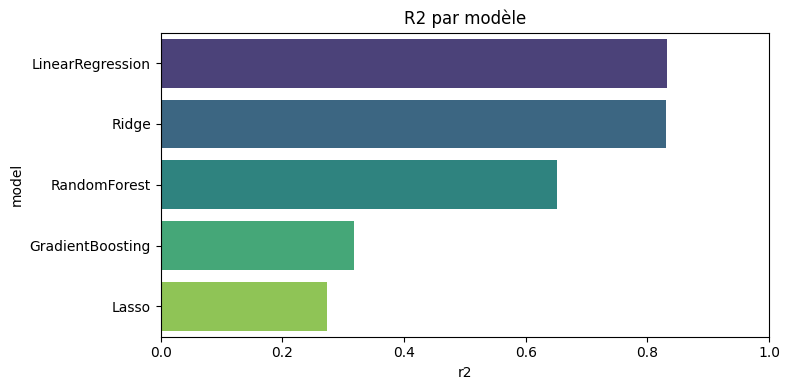

,model,r2,rmse,mae
0,LinearRegression,0.831582,5.956546,3.638054
1,Ridge,0.831509,5.957836,3.637561
2,RandomForest,0.651491,8.568563,5.234921
3,GradientBoosting,0.317491,11.990994,7.629031
4,Lasso,0.273853,12.368385,8.267196


In [8]:
# Afficher comparatif visuel
plt.figure(figsize=(8,4))
sns.barplot(x='r2', y='model', data=results_df, palette='viridis')
plt.title('R2 par modèle')
plt.xlim(0,1)
plt.tight_layout()
plt.show()
# Afficher tableau complet
results_df

## Notes
- Ajustez les hyperparamètres des modèles (ex: RandomForest max_depth, GradientBoosting learning_rate) pour de meilleures performances.
- Pour reproduire exactement le modèle de production, chargez `fare_prediction_model.pkl` si disponible et comparez ses métriques.